In [1]:
%%capture 
!pip install -U 'seaborn' 'nbformat'

In [2]:
%%capture 
!pip install scikit-learn==1.0.0
!pip install dtreeviz

In [3]:
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

#import shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context('notebook')
sns.set_style('white')

That includes records of different types of cyber attacks. The dataset contains network packets captured in the Cyber Range Lab of UNSW Canberra.

In [4]:
## loading the data
training = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0Q8REN/UNSW_NB15_training-set.csv")
testing = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0Q8REN/UNSW_NB15_testing-set.csv")
print("training ",training.shape)
print("testing ",testing.shape)

training  (82332, 45)
testing  (175341, 45)


In [5]:
# checking if all the columns are similar
all(training.columns == testing.columns)

True

In [6]:
# creating one-whole dataframe which contains all data and drop the 'id' column
df = pd.concat([training,testing]).drop('id',axis=1)
df = df.reset_index(drop=True)

# print one attack sample
df.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0


The dataset includes 43 variables regarding monitoring the network and 2 variables that define if an attack happens (label) and the types of attacks (attack_cat).

In [7]:
# getting the attack category column 
df.attack_cat.unique()

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

In this section, we briefly explore our dataset.

In [8]:
# exploring the types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  di

As we can see, some variables, that are categorical, are defined as strings. In the following cell we convert them into categorical type provided by pandas.

In [9]:
# some columns should be change from string to categoriacal
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes
    df[col] = df[col].astype('category').cat.codes
    
df['attack_cat'] = df['attack_cat'].astype('category') # keep the nomical info for attack info

attack_cat
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Normal                0
Name: count, dtype: int64


<Axes: ylabel='count'>

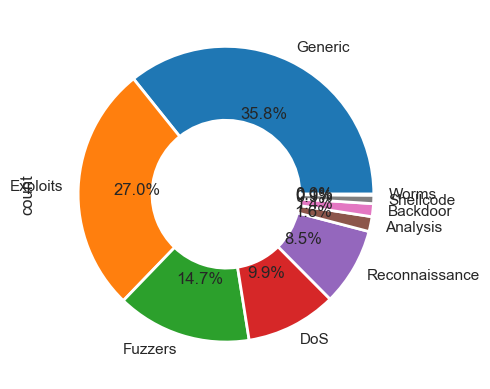

In [10]:
# explore different types of attackes
print(df[df['label']==1]
     ['attack_cat']
     .value_counts()
)
# plot the pie plot of attacks
df[df['label']==1]['attack_cat'].value_counts()\
    .plot\
    .pie(autopct='%1.1f%%',wedgeprops={'linewidth': 2, 'edgecolor': 'white', 'width': 0.50})

In [11]:
# separating the target columns in the training and testing data 
from sklearn.model_selection import train_test_split

# Split the data into variables and target variables
# let's exclude label columns 
X = df.loc[:, ~df.columns.isin(['attack_cat', 'label'])]
y = df['label'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

# Getting the list of variables
feature_names = list(X.columns)

# print the shape of train and test data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (180371, 42)
y_train shape:  (180371,)
X_test shape:  (77302, 42)
y_test shape:  (77302,)


We use a decision tree model to create a set of criteria for detecting cyber attacks in our rule-based system. The goal of this first layer of protection is to have a high recall rate, so we conduct a grid search to optimize the model toward maximizing recall.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Create a decision tree classifier
dt = DecisionTreeClassifier()

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 1.0


Using the parameters above, adjust the decision tree for high recall rate.

In [13]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

clf=grid_search.best_estimator_
#same as
#clf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1, min_samples_split=2, criterion= 'entropy')
#clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the mean absolute error of the model
recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

Recall:  1.0


One of the strengths of a decision tree is to present the sets of rules than can be utilized for rule-based systems. Here, we visualize the rules.

In [14]:
# plot the tree 
from sklearn.tree import export_text
import dtreeviz

print(":::::::> The RULES FOR HIGH RECALL RATE <::::::: \n" ,export_text(clf,feature_names=feature_names))

# visualizing the tree
viz_model = dtreeviz.model(clf,
                           X_train=X_train, y_train=y_train, 
                           feature_names=feature_names)

v = viz_model.view(fancy=True)     # render as SVG into internal object 
v

:::::::> The RULES FOR HIGH RECALL RATE <::::::: 
 |--- sttl <= 61.00
|   |--- sinpkt <= 0.00
|   |   |--- class: 1
|   |--- sinpkt >  0.00
|   |   |--- class: 0
|--- sttl >  61.00
|   |--- synack <= 0.04
|   |   |--- class: 1
|   |--- synack >  0.04
|   |   |--- class: 1



ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

We create rules for those that are identified as potential attacks (class 1) in the decision tree. Then, filter out the testing set.

We apply our rules to the testing data and call them test_2.

In [15]:
X_test = X_test.reset_index(drop=True)

# filter out testing part based on our rules
rules= "(sttl <= 61.00 & sinpkt<= 0.00) | (sttl >  61.00 )"

# getting the index of records to keep
ind = X_test.query(rules).index

# filtering test set (both X_test and y_test)
X_test_2 = X_test.loc[ind,:]
y_test_2 = y_test[ind]

print(X_test.shape)
print(X_test_2.shape)
print("filtered data" , (1- np.round(X_test_2.shape[0] / X_test.shape[0],2))*100, "%")

(77302, 42)
(59425, 42)
filtered data 23.0 %


Our simple rule-based system filtered 23% of network traffic for further analysis, demonstrating its efficacy in detecting non-threatening network activity. In practice, rule-based systems are more complex and capable of detecting the vast majority of non-threatening network traffic.

The next step involves using machine learning to detect cyber attacks by applying the trained model to the filtered data (test_2) from the previous step. It may be useful to introduce Snort, which is a powerful open-source detection software that can be utilized for network security.

Building a RandomForest Model
Random Forest is a good choice for cyber attack detection due to its high accuracy in classifying complex data patterns. The ability to interpret the results of Random Forest models also makes it easier to validate and understand the decisions it makes, leading to more effective and efficient cyber security measures.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

# Create a Random Forest model
rf = RandomForestClassifier(random_state=123)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_2)

# Calculate the mean absolute error of the model
acc = accuracy_score(y_test_2, y_pred)
rec = recall_score(y_test_2, y_pred)
per = precision_score(y_test_2, y_pred)
print("Recall: ", rec)
print("Percision: ", per)
print("Accuracy: ", acc)

Recall:  0.9574644358228257
Percision:  0.964559074993893
Accuracy:  0.9352797644089188


As we can see, the random forest algorithm showed strong performance in cyber attack detection. To gain better insight into the performance of our prediction model, let's plot a confusion matrix. It is important to note that the majority of our data contains actual attack information, as we filtered out some portion of non-threatening traffic in the previous step.

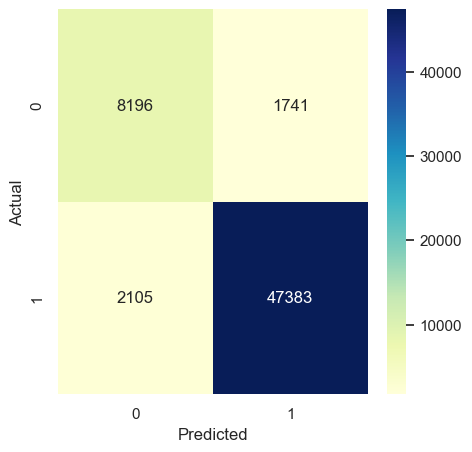

In [17]:
# plot confusion matrix
cross = pd.crosstab(pd.Series(y_test_2, name='Actual'), pd.Series(y_pred, name='Predicted'))
plt.figure(figsize=(5, 5))
sns.heatmap(cross, annot=True,fmt='d', cmap="YlGnBu")
plt.show()

In [18]:
# save the 100th tree sample in random forest in the file 
from sklearn.tree import export_text
feature_names = list(X.columns)

# Create a file and write to it
with open("Tree_output.txt", "w") as file:
    print(export_text(rf.estimators_[99], 
            spacing=3, decimals=2,
            feature_names=feature_names), file=file)

In [19]:
# creating the correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
sns.heatmap(df.corr(),vmin=-1, vmax=1,cmap='BrBG', mask=mask)

ValueError: could not convert string to float: 'Normal'

<Figure size 1200x1000 with 0 Axes>

The heatmap visualizes the correlation between variables in the dataset. It shows that certain features are highly correlated, such as tcprtt with ackdat and synack. This is because these variables measure different aspects of the same TCP connection setup process. Specifically, tcprtt is the round-trip time it takes for the TCP connection to be established, while ackdat measures the time between the SYN_ACK and ACK packets, and synack measures the time between the SYN and SYN_ACK packets. Since these variables are all related to the same underlying process of establishing a TCP connection, they are highly correlated.

Let's have a look at the correlation of variables with the cyber attack (label column):

In [20]:
# modify the headmap plot to show correlation variables to the label 
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(df.corr()[['label']].sort_values(by='label', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with the Label', fontdict={'fontsize':18}, pad=16);

ValueError: could not convert string to float: 'Normal'

<Figure size 1000x1000 with 0 Axes>

The following variables are positively correlated with cyber attacks:

 sttl: Source to destination time to live value. Attackers may use techniques such as packet fragmentation or tunneling to avoid detection or bypass security measures, which can increase the number of hops or decrease the TTL value. A higher value for sttl may be indicative of such techniques.
 
 ct_state_ttl and state: These features reflect various stages of TCP connections and may be related to port scanning, SYN flood, or DDoS attacks. Attackers may exploit the state of TCP connections using different techniques, which may be reflected in the values of ct_state_ttl and state.
 
 ct_dst_sport_ltm: This feature measures the number of connections from the same source IP to the same destination port in a short time period. Attackers may initiate multiple connections to the same port in a short time period to exploit vulnerabilities or launch attacks against a particular service or application, which may be reflected in a higher value for ct_dst_sport_ltm.
 
 rate: This feature may represent various types of traffic rates or frequencies. Attackers may generate high traffic rates or bursts of traffic to overwhelm or bypass security measures, which may be reflected in a higher value for rate.
In contrast, the following variables are negatively correlated with cyber attacks:

 swin: The size of the TCP window may decrease during an attack when attackers try to flood the network with traffic. A lower value for swin may be indicative of such attacks.

 dload: A decrease in the download speed may be indicative of an attack that consumes network bandwidth, such as DDoS attacks or worm propagation. A lower value for dload may be reflective of such attacks.

The random forest provides a list of features based on their contributions to the prediction model. The feature ranking can be accessed through RandomForest object (in our example rf) using feature_importances_ attribute.

In [21]:
# creating of ranking data frame
feature_imp = pd.DataFrame({'Name':X.columns, 'Importance':rf.feature_importances_})

# sorting the features based on their importance value
feature_imp = feature_imp.sort_values('Importance',ascending=False).reset_index(drop=True)

# show only 10 most important feature in style of gradien of colores
feature_imp[:10].style.background_gradient()

,Name,Importance
0,sttl,0.139708
1,ct_state_ttl,0.107578
2,rate,0.052387
3,dload,0.049926
4,sload,0.047473
5,sbytes,0.040504
6,ct_dst_src_ltm,0.040064
7,smean,0.039948
8,ct_srv_dst,0.036520
9,dbytes,0.034286


<Axes: >

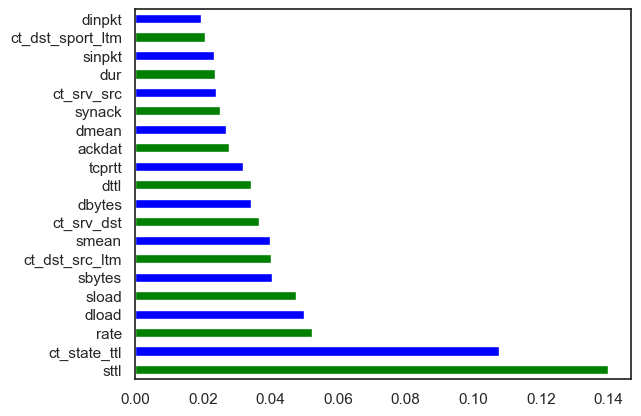

In [22]:
# plot the important features
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',color=['g','b']*5)

Let's select only the top 10 features and find their associations with the type of cyber attack.

In [23]:
# get the names of top 10 features
top10= feature_imp.Name[:10].tolist()

# get the attack names
attack_names = np.array(df['attack_cat'].unique())

# selecting only top 10 features
X_top = df.loc[:, df.columns.isin(top10)]
# need to convert the catagorical data into numbers (e.g. normal ->0, Blackdoor ->2)
y_top = pd.factorize(df['attack_cat'])[0]


# for the purpose of visualization we set max_depth to 6 in order to be shown in the notebook
clf_top10 = DecisionTreeClassifier(max_depth=6)

# Split the data into train and test sets
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.3, random_state=11)

# Train the model on the training data
clf_top10.fit(X_train_top, y_train_top)

# visualizing the tree
viz_model = dtreeviz.model(clf_top10,
                           X_train=X_train_top, y_train=y_train_top, 
                           class_names=attack_names,
                           feature_names=top10)

v = viz_model.view(fancy=False,scale=1) # render as SVG into internal object 
v
#v.save("The_100th_tree.svg") # if you willing to save the 

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

For a better understanding, we can randomly select a point and visualize the path for prediction.

In [24]:
# get a random point
rand = np.random.randint(0, len(X))
sample_point = X.iloc[rand,:].values

# visualizing the path for the point
v = viz_model.view(fancy=True,scale=1.5,x=sample_point,show_just_path=True)
v

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

please keep in mind that we utilize a simple decision tree for visualization (above cells), and random forest can outperform decision tree in predicting the type of attack.

In [ ]:
List of all features with description

In [ ]:
# he data was processed using Argus and Bro-ID tools, resulting in 49 features with class labels.

No.	Name	Type	Description
1	srcip	nominal	Source IP address
2	sport	integer	Source port number
3	dstip	nominal	Destination IP address
4	dsport	integer	Destination port number
5	proto	nominal	Transaction protocol
6	state	nominal	Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)
7	dur	Float	Record total duration
8	sbytes	Integer	Source to destination transaction bytes
9	dbytes	Integer	Destination to source transaction bytes
10	sttl	Integer	Source to destination time to live value
11	dttl	Integer	Destination to source time to live value
12	sloss	Integer	Source packets retransmitted or dropped
13	dloss	Integer	Destination packets retransmitted or dropped
14	service	nominal	http, ftp, smtp, ssh, dns, ftp-data ,irc and (-) if not much used service
15	Sload	Float	Source bits per second
16	Dload	Float	Destination bits per second
17	Spkts	integer	Source to destination packet count
18	Dpkts	integer	Destination to source packet count
19	swin	integer	Source TCP window advertisement value
20	dwin	integer	Destination TCP window advertisement value
21	stcpb	integer	Source TCP base sequence number
22	dtcpb	integer	Destination TCP base sequence number
23	smeansz	integer	Mean of the ?ow packet size transmitted by the src
24	dmeansz	integer	Mean of the ?ow packet size transmitted by the dst
25	trans_depth	integer	Represents the pipelined depth into the connection of http request/response transaction
26	res_bdy_len	integer	Actual uncompressed content size of the data transferred from the serverís http service.
27	Sjit	Float	Source jitter (mSec)
28	Djit	Float	Destination jitter (mSec)
29	Stime	Timestamp	record start time
30	Ltime	Timestamp	record last time
31	Sintpkt	Float	Source interpacket arrival time (mSec)
32	Dintpkt	Float	Destination interpacket arrival time (mSec)
33	tcprtt	Float	TCP connection setup round-trip time, the sum of ísynackí and íackdatí.
34	synack	Float	TCP connection setup time, the time between the SYN and the SYN_ACK packets.
35	ackdat	Float	TCP connection setup time, the time between the SYN_ACK and the ACK packets.
36	is_sm_ips_ports	Binary	If source (1) and destination (3)IP addresses equal and port numbers (2)(4) equal then, this variable takes value 1 else 0
37	ct_state_ttl	Integer	No. for each state (6) according to specific range of values for source/destination time to live (10) (11).
38	ct_flw_http_mthd	Integer	No. of flows that has methods such as Get and Post in http service.
39	is_ftp_login	Binary	If the ftp session is accessed by user and password then 1 else 0.
40	ct_ftp_cmd	integer	No of flows that has a command in ftp session.
41	ct_srv_src	integer	No. of connections that contain the same service (14) and source address (1) in 100 connections according to the last time (26).
42	ct_srv_dst	integer	No. of connections that contain the same service (14) and destination address (3) in 100 connections according to the last time (26).
43	ct_dst_ltm	integer	No. of connections of the same destination address (3) in 100 connections according to the last time (26).
44	ct_src_ ltm	integer	No. of connections of the same source address (1) in 100 connections according to the last time (26).
45	ct_src_dport_ltm	integer	No of connections of the same source address (1) and the destination port (4) in 100 connections according to the last time (26).
46	ct_dst_sport_ltm	integer	No of connections of the same destination address (3) and the source port (2) in 100 connections according to the last time (26).
47	ct_dst_src_ltm	integer	No of connections of the same source (1) and the destination (3) address in in 100 connections according to the last time (26).
48	attack_cat	nominal	The name of each attack category. In this data set , nine categories e.g. Fuzzers, Analysis, Backdoors, DoS Exploits, Generic, Reconnaissance, Shellcode and Worms
49	Label	binary	0 for normal and 1 for attack records